In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import tdt
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import xarray as xr
import yaml

import kdephys.hypno as kh
import kdephys.pd as kpd
import kdephys.xr as kx
import kdephys.utils as ku
import kdephys.ssfm as ss

import acr.subjects as subs
import acr
import acr.utils as acu
import plotly.express as px
plt.style.use('acr_plots.mplstyle')
import os
from itertools import cycle

/home/kdriessen/github_t2/kdephys/kdephys/xr/utils.py:4: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


In [47]:
params = {}
params['subject'] = 'ACR_12'
params['stores'] = ['EEGr', 'NNXr', 'EMGr']
params['ds-list'] = ['control1', 'control1-bl', 'laser1', 'laser1-bl']
params['channels'] = {'EEGr': [1, 2], 'EMGr': [1, 2], 'NNXr': list(range(1, 17))}
subject_info_gen(params=params)

read from t=0s to t=1557.03s
read from t=0s to t=2982.67s
read from t=0s to t=1679.86s
read from t=0s to t=1572.34s
read from t=0s to t=2589.87s
read from t=0s to t=1651.55s
read from t=0s to t=510.5s
read from t=0s to t=1617.32s
read from t=0s to t=1567.1s


In [2]:
def load_subject_info(subject):
    path = f"/Volumes/opto_loc/Data/ACR_PROJECT_MATERIALS/{subject}/subject_info.yml"
    with open(path, 'r') as f:
        data = yaml.safe_load(f)
    return data

In [3]:
def add_stim_mask(onsets, offsets, data, freq=None):
    mask = np.zeros_like(data.datetime.values, dtype=bool)
    for on, off in zip(onsets, offsets):
        mask |= (data.datetime.values >= on) & (data.datetime.values <= off)
    # add stim coordinate to the data
    data = data.assign_coords(stim=('datetime', mask))
    if freq:
        assert len(freq) == 1
        data = data.assign_attrs(stim_freq=freq[0])
    return data


In [198]:
d = add_stim_mask(on, off, data, freq)

In [4]:
path = f'/Volumes/opto_loc/Data/ACR_14/ACR_14-ep-test1/'
ed = kx.io.get_data(path, 'EEGr', channel=[1, 2])
eps = tdt.read_block(path, evtype=['epocs'])
wav = tdt.read_block(path, evtype=['streams'])

read from t=0s to t=140.16s
Using 1017.2526 Hz as SEV sampling rate for EEGr
read from t=0s to t=140.16s
read from t=0s to t=140.16s
Using 152.5879 Hz as SEV sampling rate for EEG_
Using 305.1758 Hz as SEV sampling rate for LFP_
Using 305.1758 Hz as SEV sampling rate for LFPo
Using 24414.0625 Hz as SEV sampling rate for NNXo
Using 1017.2526 Hz as SEV sampling rate for EEGr
Using 1017.2526 Hz as SEV sampling rate for EMGr
Using 24414.0625 Hz as SEV sampling rate for NNXr


In [5]:
def epocs_as_dt(subject, recording, store='Wfrq'):
    # get the subject info file
    info = load_subject_info(subject)
    # get the start time of the recording
    rec_start = np.datetime64(info['rec_times'][recording]['start'])
    # load the epocs
    path = acr.io.acr_path(subject, recording)
    epocs = tdt.read_block(path, evtype=['epocs'])
    # get the epoc data
    ep = epocs.epocs[store]
    # get the onsets
    onsets = ep.onset
    # get the offsets
    offsets = ep.offset
    # convert to datetime
    onsets = rec_start + (onsets*1e9).astype('timedelta64[ns]')
    offsets = rec_start + (offsets*1e9).astype('timedelta64[ns]')
    # return the onsets and offsets
    return onsets, offsets

In [6]:
epocs_as_dt('ACR_14', 'ep-test1', 'Btn_')

read from t=0s to t=140.16s


(array(['2022-10-01T11:36:48.182954520', '2022-10-01T11:36:58.189359640',
        '2022-10-01T11:38:56.513829399'], dtype='datetime64[ns]'),
 array(['2022-10-01T11:36:54.158608920', '2022-10-01T11:37:02.076750360',
        '2022-10-01T11:38:58.142972439'], dtype='datetime64[ns]'))

In [ ]:
def epoc_extractor(subject, recording, epoc_store, t1=0, t2=0):
    # get the subject info file
    info = load_subject_info(subject)
    # get the start time of the recording
    rec_start = np.datetime64(info['rec_times'][recording]['start'])
    rec_end = np.datetime64(info['rec_times'][recording]['end'])
    # load the epocs
    path = info['paths'][recording]
    epocs = tdt.read_block(path, evtype=['epocs'])
    # get the epoc data
    ep = epocs.epocs[epoc_store]
    # get the onsets
    onsets = ep.onset
    # get the offsets
    offsets = ep.offset
    # convert to datetime
    onsets = rec_start + (onsets*1e9).astype('timedelta64[ns]')
    offsets = rec_start + (offsets*1e9).astype('timedelta64[ns]')
    # return the onsets and offsets
    return onsets, offsets

# Specific for Wav2 stores

occasionally (ACR_13 and ACR_14 only, hopefully) we need to pull out values where the Wav2 store is above a certain threshold, defined by the offset value. These functions accomplish that. 

In [90]:
def get_wav2_up_data(subject, exp, t1=0, t2=0, store='Wav2', thresh=1.1e6):
    """returns the times where Wav2 store is greater than 1.5, which should equal the laser on times
    """
    info = load_subject_info(subject)
    w = kx.io.get_data(info['paths'][exp], store, t1=t1, t2=t2)
    w_on = w.where(w > thresh, drop=True)
    f, ax = plt.subplots(figsize=(15, 5))
    ax.plot(w_on.datetime, w_on.data)
    return w_on

read from t=0s to t=140.16s


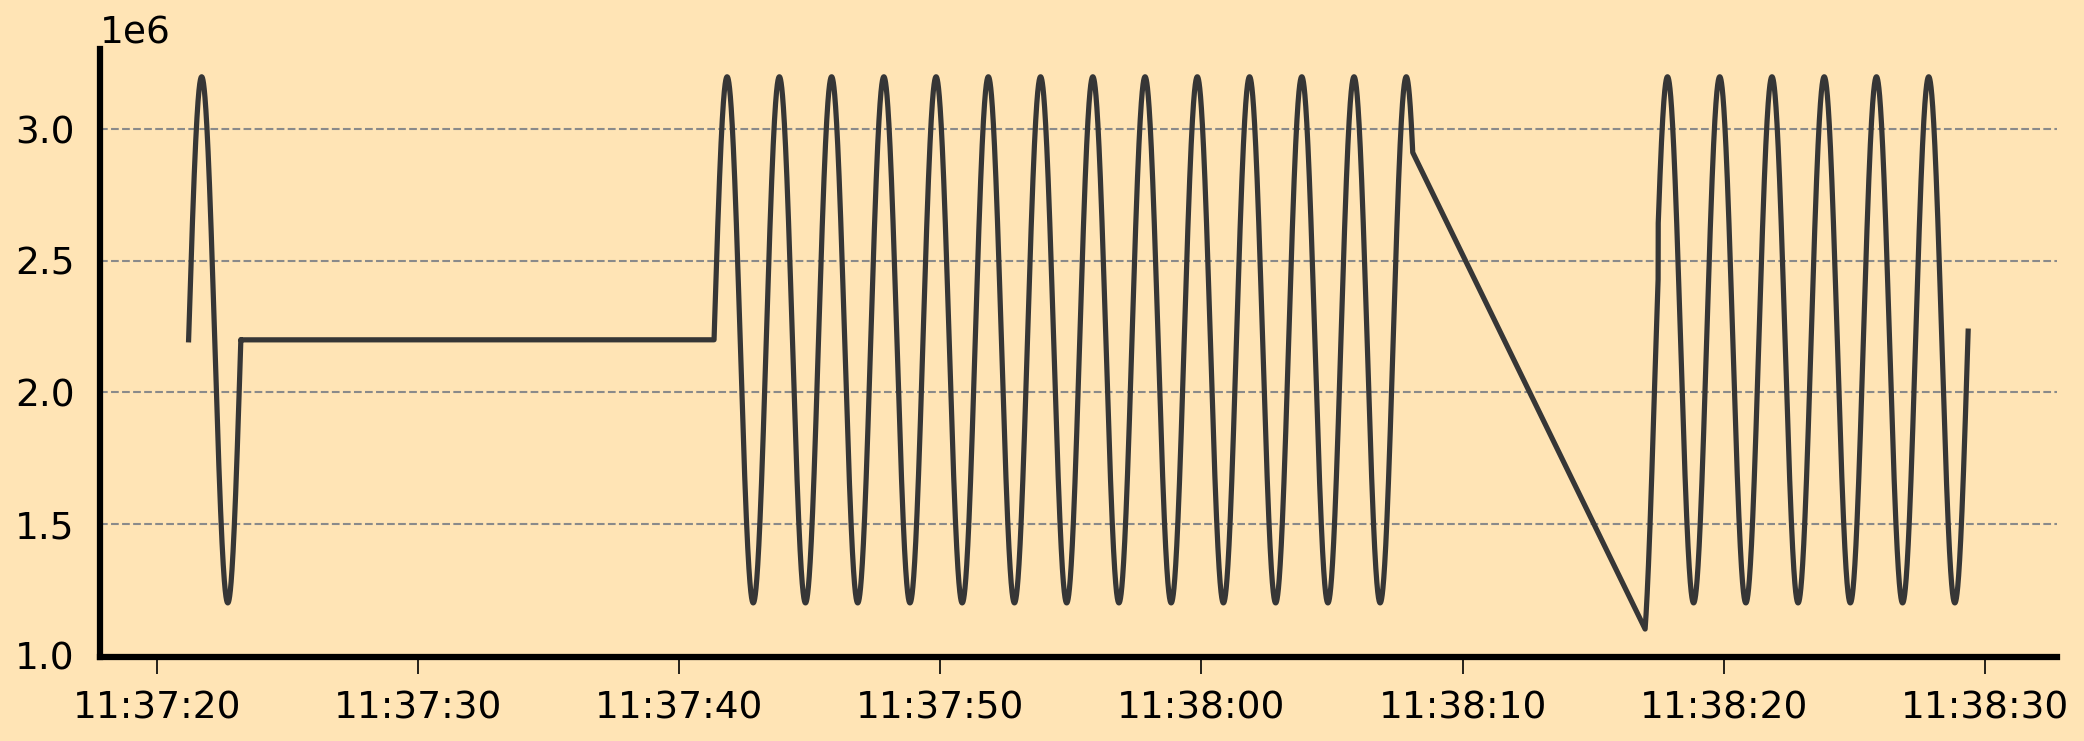

In [91]:
wav_up = get_wav2_up_data('ACR_14', 'ep-test1', t1=0, t2=0, store='Wav2', thresh=1.1e6)

In [92]:
def get_wav2_on_and_off(wav2_up):
    times = wav2_up.datetime.values
    ons = []
    offs = []
    time_int = times[1] - times[0]
    for i in range(len(times)):
        if i == 0:
            ons.append(times[i])
        elif i == (len(times)-1):
            offs.append(times[i])
        else:
            interval = times[i] - times[i-1]
            if interval > (time_int*5):
                ons.append(times[i])
                offs.append(times[i-1])
    return ons, offs

In [93]:
ons, offs = get_wav2_on_and_off(wav_up)